In [1]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist
from scipy.stats import multivariate_normal

from frouros.callbacks import PermutationTestDistanceBased
from frouros.detectors.data_drift import MMD
from frouros.utils.kernels import rbf_kernel

In [2]:
x_mean = np.ones(2)
x_cov = 2*np.eye(2)
print(f"x_mean = {x_mean}\nx_cov = {x_cov}")

x_mean = [1. 1.]
x_cov = [[2. 0.]
 [0. 2.]]


In [3]:
y_mean = np.zeros(2)
y_cov = np.eye(2) + 1
print(f"y_mean = {y_mean}\ny_cov = {y_cov}")

y_mean = [0. 0.]
y_cov = [[2. 1.]
 [1. 2.]]


In [4]:
seed = 31
np.random.seed(seed)

num_samples = 200

X_ref = np.random.multivariate_normal(
    mean=x_mean,
    cov=x_cov,
    size=num_samples,
)
X_test = np.random.multivariate_normal(
    mean=y_mean,
    cov=y_cov,
    size=num_samples,
)

In [5]:
alpha = 0.01

In [6]:
sigma = np.median(
    pdist(
        X=np.vstack((X_ref, X_test)),
        metric="euclidean",
    )) / 2
sigma

1.2590251585463998

In [7]:
detector = MMD(
    kernel=partial(
        rbf_kernel,
        sigma=sigma,
    ),
    callbacks=[
        PermutationTestDistanceBased(
            num_permutations=1000,
            random_state=seed,
            num_jobs=-1,
            name="permutation_test",
            verbose=True,
        ),
    ],
)
detector.fit(X=X_ref)
mmd, callbacks_log = detector.compare(X=X_test)
p_value = callbacks_log["permutation_test"]["p_value"]

100%|██████████| 1000/1000 [00:01<00:00, 539.09it/s]


In [8]:
print(f"MMD statistic={round(mmd.distance, 3)}, p-value={round(p_value, 3)}")
if p_value <= alpha:
    print("Drift detected. We can reject H0, so both samples come from different distributions.")
else:
    print("No drift detected. We fail to reject H0, so both samples come from the same distribution.")

MMD statistic=0.088, p-value=0.0
Drift detected. We can reject H0, so both samples come from different distributions.


visualize both samples with their respective distributions.

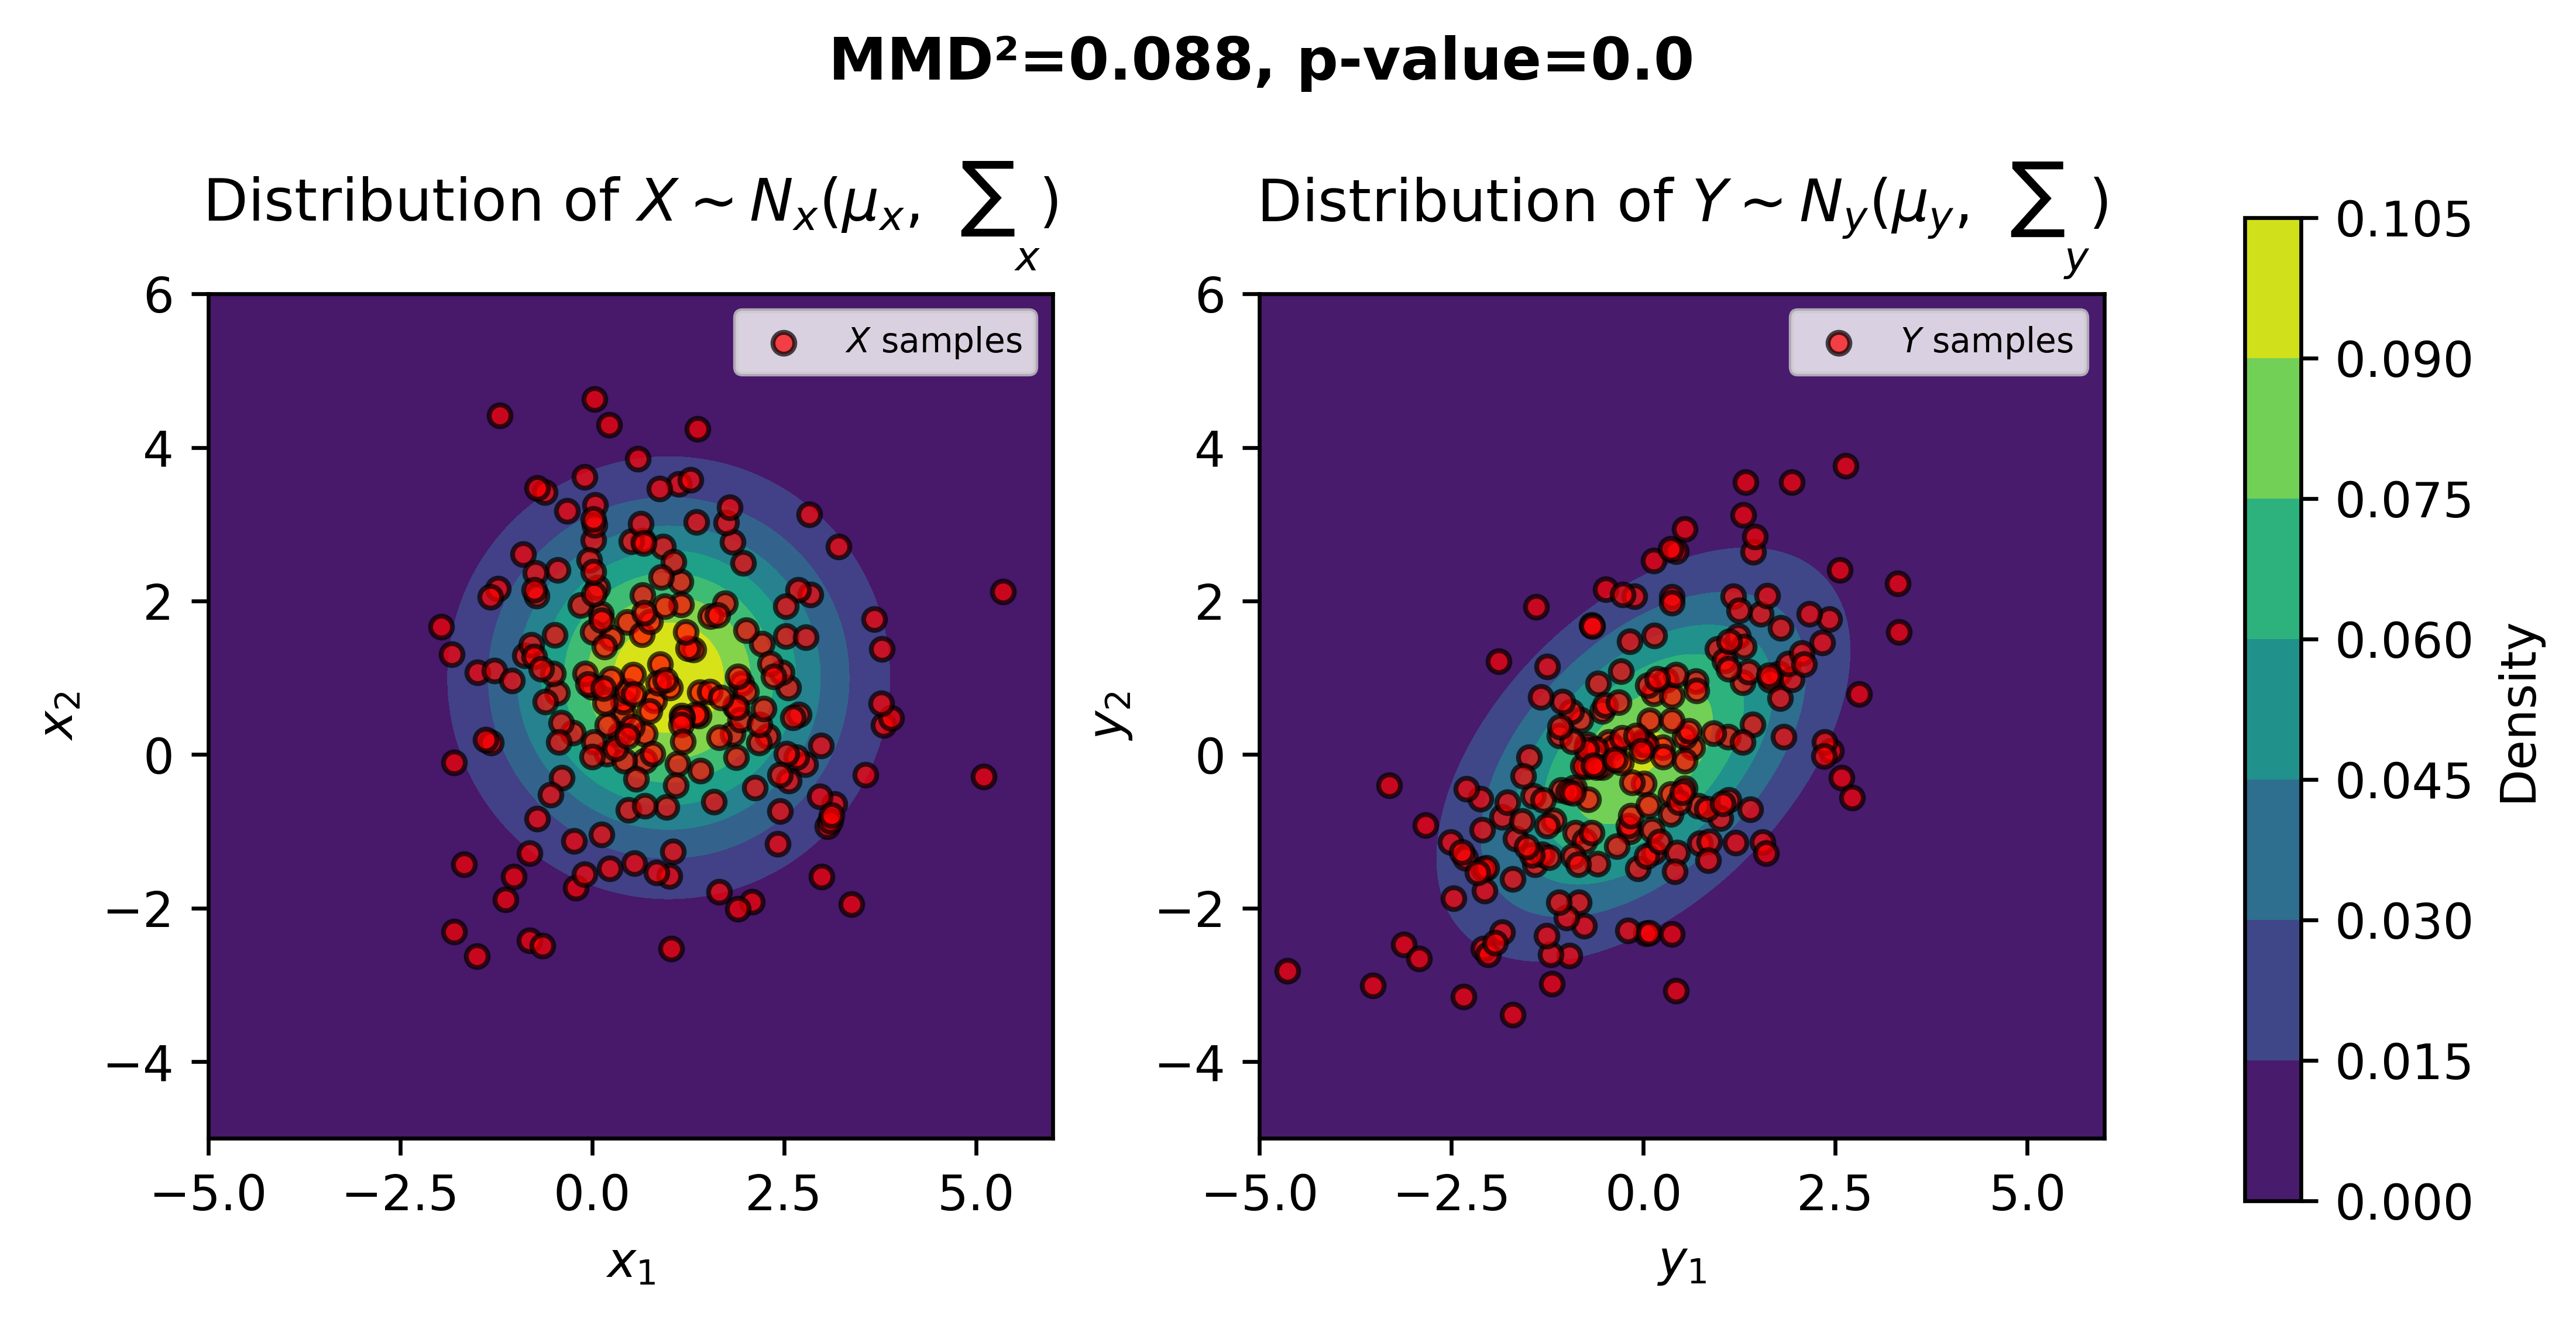

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=600)

x1_ref_min, x2_ref_min = X_ref.min(axis=0)
x1_test_min, x2_test_min = X_test.min(axis=0)

x1_ref_max, x2_ref_max = X_ref.max(axis=0)
x1_test_max, x2_test_max = X_test.max(axis=0)

x_min = np.floor(np.min([x1_ref_min, x1_test_min, x2_ref_min, x2_test_min]))
x_max = np.ceil(np.max([x1_ref_max, x1_test_max, x2_ref_max, x2_test_max]))
x_max = x_max if x_min != x_max else x_max + 1

x1_val = np.linspace(x_min, x_max, num=num_samples)
x2_val = np.linspace(x_min, x_max, num=num_samples)

x1, x2 = np.meshgrid(x1_val, x2_val)

px_grid = np.zeros((num_samples, num_samples))
qy_grid = np.zeros((num_samples, num_samples))

for i in range(num_samples):
    for j in range(num_samples):
        px_grid[i, j] = multivariate_normal.pdf([x1_val[i], x2_val[j]], x_mean, x_cov)
        qy_grid[i, j] = multivariate_normal.pdf([x1_val[i], x2_val[j]], y_mean, y_cov)

marker = "o"
facecolor = "r"
edgecolor = "k"
alpha = 0.7
marker_size = 20

CS1 = ax1.contourf(x1, x2, px_grid)
ax1.set_title("Distribution of $X \sim N_{x}(\mu_{x}, \sum_{\qquad x})$", pad=15)
ax1.set_ylabel('$x_2$')
ax1.set_xlabel('$x_1$')
ax1.set_aspect('equal')
ax1.scatter(X_ref[:, 0], X_ref[:, 1],
            label="$X$ samples",
            marker=marker,
            facecolor=facecolor,
            edgecolor=edgecolor,
            alpha=alpha,
            s=marker_size)
ax1.legend(fontsize=7)

CS2 = ax2.contourf(x1, x2, qy_grid)
ax2.set_title("Distribution of $Y \sim N_{y}(\mu_{y}, \sum_{\qquad y})$", pad=15)
ax2.set_xlabel('$y_1$')
ax2.set_ylabel('$y_2$')
ax2.set_aspect('equal')
ax2.scatter(X_test[:, 0], X_test[:, 1],
            label="$Y$ samples",
            marker=marker,
            facecolor=facecolor,
            edgecolor=edgecolor,
            alpha=alpha,
            s=marker_size)
ax2.legend(fontsize=7)

fig.subplots_adjust(right=0.8,
                    wspace=0.245)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(CS2, cax=cbar_ax)
cbar.ax.set_ylabel('Density')
plt.suptitle(f"MMD²={round(mmd.distance, 3)}, p-value={round(p_value, 3)}", y=0.98, fontweight="bold")
plt.show()